In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
# btc_file = '../Bitcoin_data/all_together.csv'

df_btc = pd.read_csv(btc_file, sep=';')

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [3]:
scaled_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2025-03-19T00:00:00.000Z,2025-03-19T23:59:59.999Z,2025-03-19T23:44:00.000Z,2025-03-19T02:07:00.000Z,2781,82718.804258,87021.185805,82569.726895,86854.225960,3.493196e+10,1.723489e+12,2025-03-19T23:59:59.999Z
1,2025-03-18T00:00:00.000Z,2025-03-18T23:59:59.999Z,2025-03-18T00:00:00.000Z,2025-03-18T13:59:00.000Z,2781,84075.715672,84075.715672,81179.990163,82718.502318,2.409577e+10,1.641035e+12,2025-03-18T23:59:59.999Z
2,2025-03-17T00:00:00.000Z,2025-03-17T23:59:59.999Z,2025-03-17T19:48:00.000Z,2025-03-17T14:12:00.000Z,2781,82576.334278,84725.325982,82492.152537,84075.688697,2.509279e+10,1.667917e+12,2025-03-17T23:59:59.999Z
3,2025-03-16T00:00:00.000Z,2025-03-16T23:59:59.999Z,2025-03-16T16:10:00.000Z,2025-03-16T23:10:00.000Z,2781,84333.321617,85051.598485,82017.904714,82579.690892,2.133027e+10,1.638136e+12,2025-03-16T23:59:59.999Z
4,2025-03-15T00:00:00.000Z,2025-03-15T23:59:59.999Z,2025-03-15T03:35:00.000Z,2025-03-15T08:19:00.000Z,2781,83968.405950,84672.672161,83639.594858,84343.108458,1.365049e+10,1.673151e+12,2025-03-15T23:59:59.999Z


In [4]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
                          name      open      high       low     close  \
timestamp                                                                
2025-03-19T23:59:59.999Z  2781  0.577186  0.616542  0.595481  0.651858   
2025-03-18T23:59:59.999Z  2781  0.601675  0.565420  0.570740  0.577225   
2025-03-17T23:59:59.999Z  2781  0.574615  0.576695  0.594100  0.601717   
2025-03-16T23:59:59.999Z  2781  0.606324  0.582358  0.585657  0.574720   
2025-03-15T23:59:59.999Z  2781  0.599738  0.575781  0.614528  0.606543   

                            volume  marketCap  
timestamp                                      
2025-03-19T23:59:59.999Z  0.179920   0.657170  
2025-03-18T23:59:59.999Z  0.102163   0.582669  
2025-03-17T23:59:59.999Z  0.109318   0.606958  
2025-03-16T23:59:59.999Z  0.082319   0.580049  
2025-03-15T23:59:59.999Z  0.027212   0.611688  
Shape: (399, 7)


In [5]:
def prepare_data(df, window_size=5):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        out = lstm_out[:, -1, :]    
        out = self.fc(out)          
        return out

In [7]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                              target_scaler, results_dict, epochs=100, lr=0.001,
                              early_stopping_threshold=0.1, patience=10):
    print(f"Training {model_name}...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, X_train.shape[1], 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, X_test.shape[1], 1).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)

    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        if train_loss < early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1} (loss {train_loss:.6f} < {early_stopping_threshold})")
            break

        if train_loss < best_loss - 1e-5:
            best_loss = train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}")

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()

    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)

    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,
        'X_test': X_test,
        'y_test': y_test
    }

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)

    return model


In [8]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [9]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = 1

    for lr in learning_rates:
        for epochs in epochs_list:
            experiment_count += 1
            
            model = LSTMModel(input_size=input_size, hidden_size=64)
            model_name = f"LSTM_w{window_size}_hs64_lr{lr}_e{epochs}"
            
            print(f"\n[{experiment_count}/{total_experiments}] {model_name}")
            
            run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                                      target_scaler, results, epochs=epochs, lr=lr)

print("\n" + "=" * 80)
print(" ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



 Window size: 5
Training set shape: (315, 30)
Test set shape: (79, 30)

[1/90] LSTM_w5_hs64_lr0.001_e50
Training LSTM_w5_hs64_lr0.001_e50...
Early stopping at epoch 15 (loss 0.091243 < 0.1)
RMSE: 9601.9768, MAE: 7722.5324
--------------------------------------------------

[2/90] LSTM_w5_hs64_lr0.001_e100
Training LSTM_w5_hs64_lr0.001_e100...
Early stopping at epoch 15 (loss 0.085059 < 0.1)
RMSE: 9404.8510, MAE: 7692.6767
--------------------------------------------------

[3/90] LSTM_w5_hs64_lr0.001_e1000
Training LSTM_w5_hs64_lr0.001_e1000...
Early stopping at epoch 14 (loss 0.098108 < 0.1)
RMSE: 7627.7416, MAE: 5586.5081
--------------------------------------------------

[4/90] LSTM_w5_hs64_lr0.01_e50
Training LSTM_w5_hs64_lr0.01_e50...
Early stopping at epoch 3 (loss 0.067800 < 0.1)
RMSE: 27855.3078, MAE: 27454.8782
--------------------------------------------------

[5/90] LSTM_w5_hs64_lr0.01_e100
Training LSTM_w5_hs64_lr0.01_e100...
Early stopping at epoch 3 (loss 0.076175 < 0.

In [10]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
LSTM_w10_hs64_lr0.001_e100               7038.7462  5095.7596  0.091429    
LSTM_w10_hs64_lr0.001_e50                7232.9848  5200.5105  0.099065    
LSTM_w10_hs64_lr0.01_e100                7425.5633  5404.7238  0.071398    
LSTM_w15_hs64_lr0.001_e1000              7546.4165  5458.5851  0.096140    
LSTM_w5_hs64_lr0.001_e1000               7627.7416  5586.5081  0.098108    
LSTM_w15_hs64_lr0.001_e50                8005.0538  5996.2580  0.091546    
LSTM_w10_hs64_lr0.001_e1000              8103.0183  6010.6964  0.098764    
LSTM_w15_hs64_lr0.001_e100               8823.5767  6871.9581  0.089971    
LSTM_w5_hs64_lr0.001_e100                9404.8510  7692.6767  0.085059    
LSTM_w5_hs64_lr0.001_e50                 9601.9768  7722.5324  0.091243    
LSTM_w5_hs64_lr0.01_e1000                14528.6052 13627.6959 0.091922    
LSTM_w1

--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


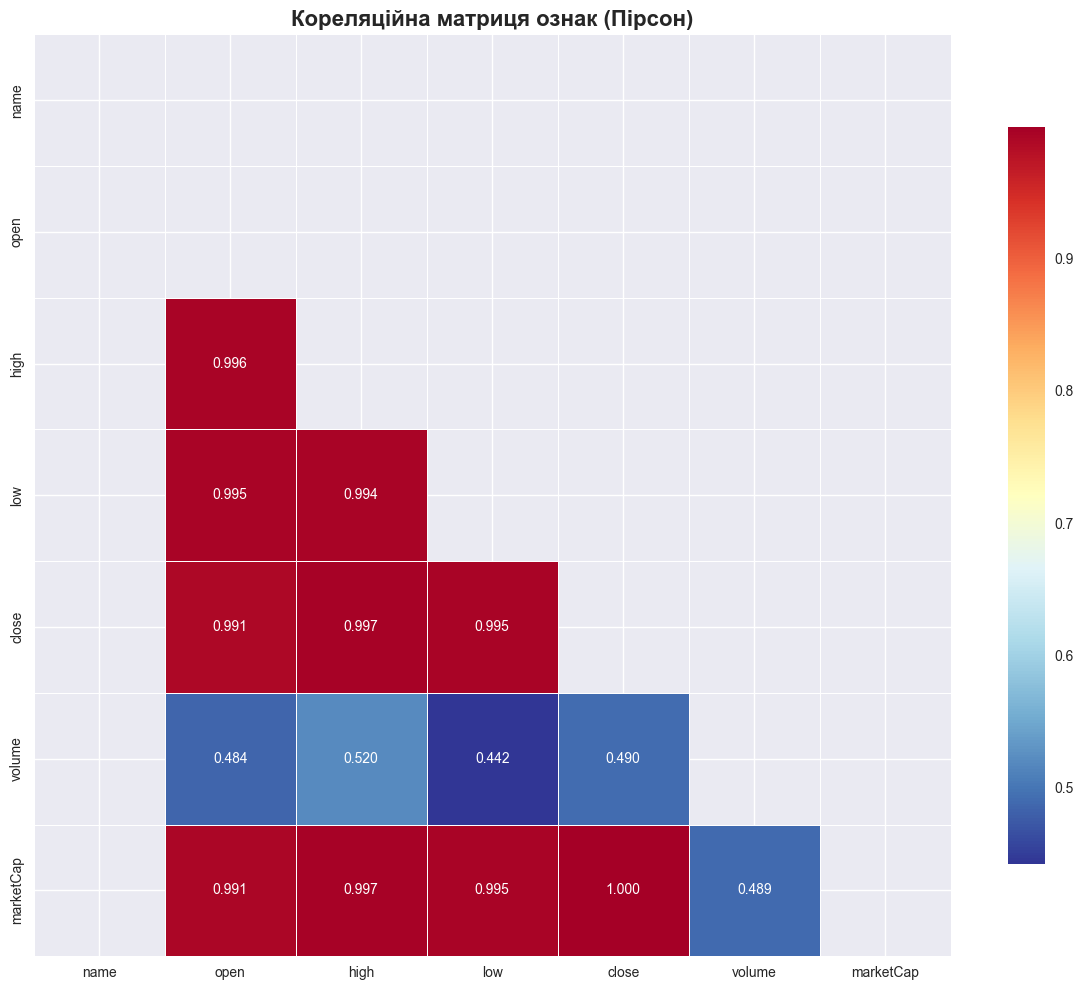


 Найсильніші кореляції:
 1. close        ↔ marketCap   :  1.000
 2. high         ↔ marketCap   :  0.997
 3. high         ↔ close       :  0.997
 4. open         ↔ high        :  0.996
 5. low          ↔ marketCap   :  0.995
 6. low          ↔ close       :  0.995
 7. open         ↔ low         :  0.995
 8. high         ↔ low         :  0.994
 9. open         ↔ marketCap   :  0.991
10. open         ↔ close       :  0.991

 РОЗПОДІЛ ОЗНАК


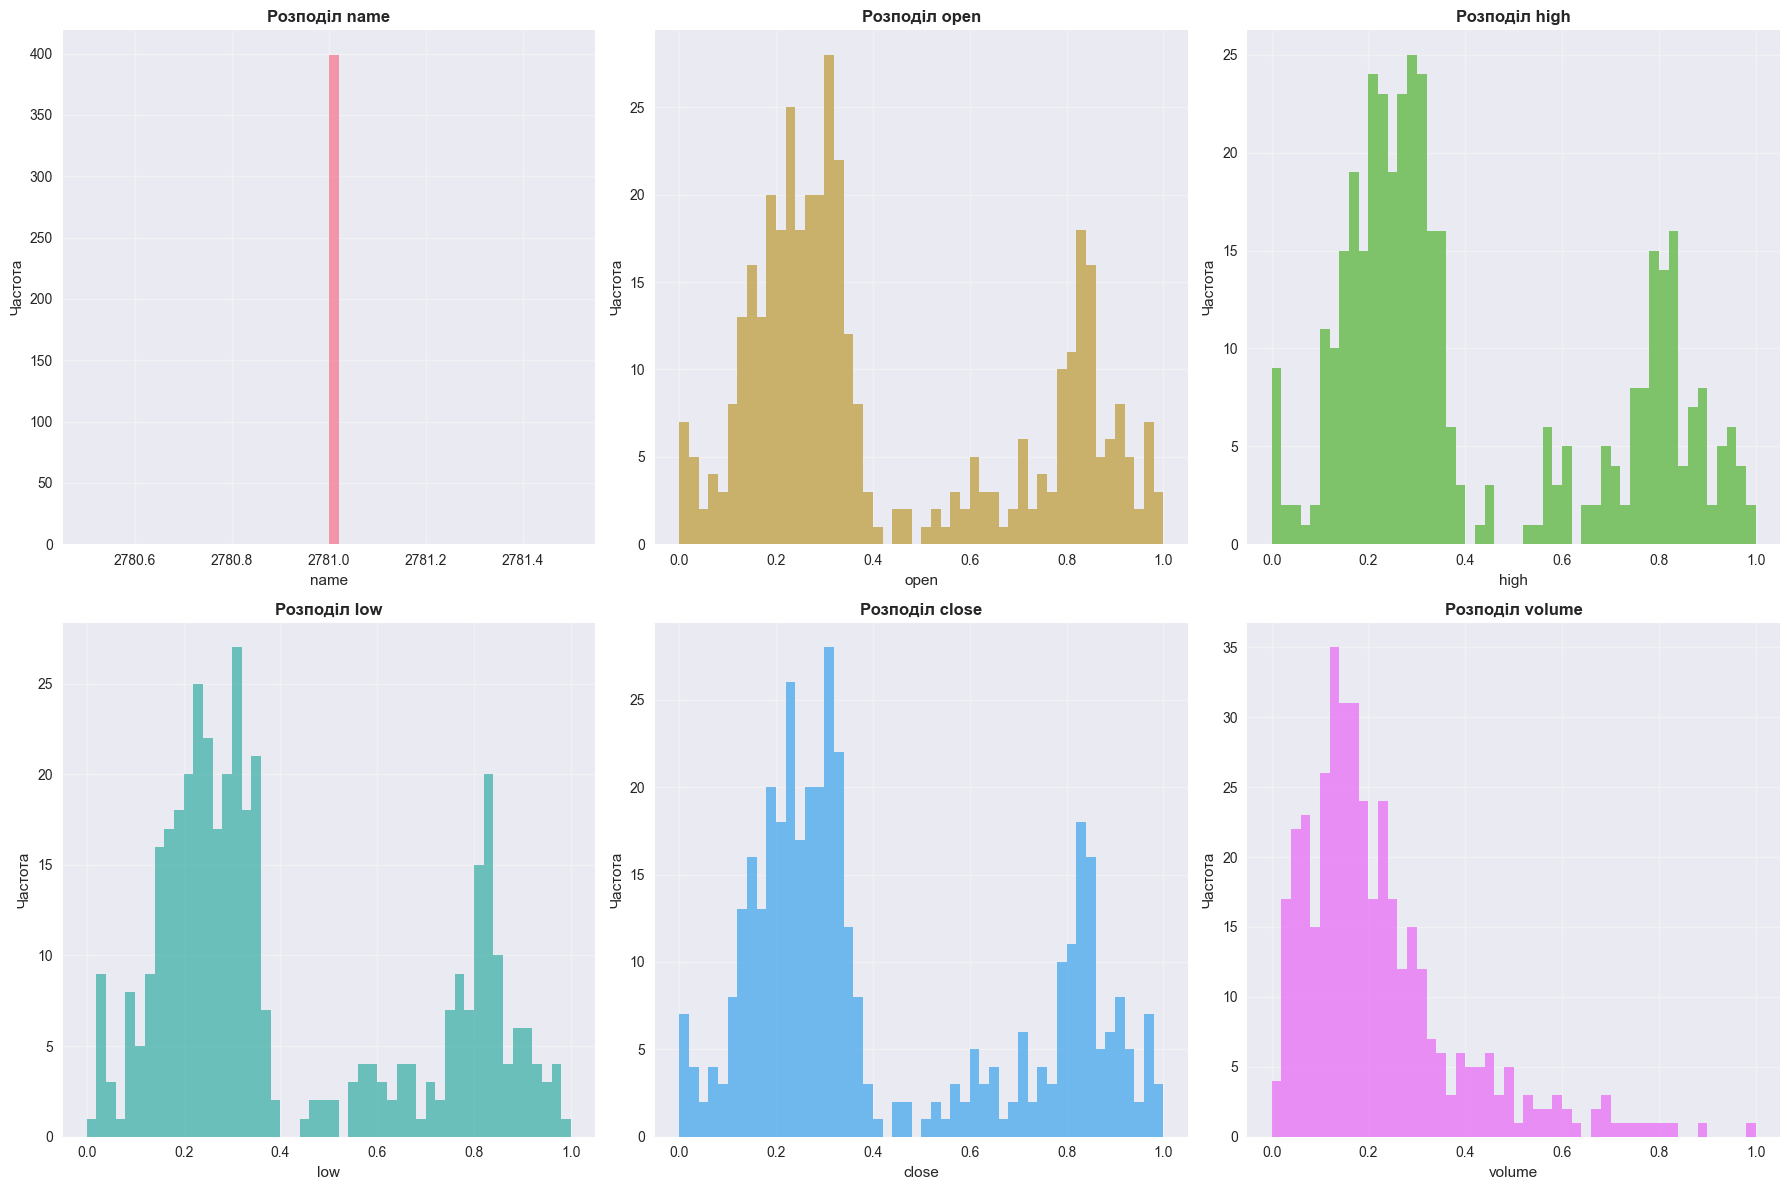


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: LSTM_w10_hs64_lr0.001_e100


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 60

In [11]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)